In [1]:
## Initial Exploration of the 311 data
#####################################################################
# This file explores the Analyze Boston 311 data
# to import the data we must first run the import-311-data.py file
# this file also loads pandas
#####################################################################
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
import numpy as np
import folium # mapping
from folium.plugins import HeatMap
import matplotlib.pyplot as plt # visualization

%matplotlib inline


%run -t import-311-data.py

# clean up some columns 

# convert the closed date to a date time format
df_311['closed_dt'] = pd.to_datetime(df_311['closed_dt'])

df_311['open_dt'] = pd.to_datetime(df_311['open_dt'])

# collapse dates down to month-year
df_311['close_date'] = df_311['closed_dt'].dt.to_period('M')

df_311['open_date'] = df_311['open_dt'].dt.to_period('M')

# create year columns
df_311['close_year'] = df_311['closed_dt'].dt.year

df_311['open_year'] = df_311['open_dt'].dt.year

# convert our closed variable to binary, 1/0
df_311['closed'] = df_311['case_status'].apply(lambda x: 1 if x=='Closed' else 0)

df_311['opened'] = df_311['case_status'].apply(lambda x: 1 if x=='Open' else 0)


/Users/jacobpstein/Documents/Georgetown SCS/capstone/boston-311/02 code/import-311-data.py:24: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(url) for url in urls]
/Users/jacobpstein/Documents/Georgetown SCS/capstone/boston-311/02 code/import-311-data.py:24: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(url) for url in urls]



IPython CPU timings (estimated):
  User   :      17.85 s.
  System :       2.72 s.
Wall time:      68.38 s.


In [2]:
# let's see how many rows and columns we have
df_311.shape

(2434234, 35)

In [4]:
df_311.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2444791 entries, 0 to 2444790
Data columns (total 36 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   case_enquiry_id                 int64         
 1   open_dt                         datetime64[ns]
 2   target_dt                       object        
 3   closed_dt                       datetime64[ns]
 4   ontime                          object        
 5   case_status                     object        
 6   closure_reason                  object        
 7   case_title                      object        
 8   subject                         object        
 9   reason                          object        
 10  type                            object        
 11  queue                           object        
 12  department                      object        
 13  submittedphoto                  object        
 14  closedphoto                     object        
 15

In [5]:
# total unique observations per column
df_311.nunique()

case_enquiry_id                   2444791
open_dt                           2225131
target_dt                         1282251
closed_dt                         2174731
ontime                                  2
case_status                             2
closure_reason                    1811681
case_title                          23828
subject                                14
reason                                 54
type                                  211
queue                                 194
department                             18
submittedphoto                     704064
closedphoto                        363444
location                           146648
fire_district                          12
pwd_district                           22
city_council_district                  11
police_district                        24
neighborhood                           24
neighborhood_services_district         17
ward                                   56
precinct                          

In [6]:
# notably, we only have a handful of truly numeric values
df_311.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

# 9% of calls remain open


,case_enquiry_id,location_zipcode,latitude,longitude,close_year,open_year,closed,opened,on_time
count,2444791.000000,1879199.000000,2444791.000000,2444791.000000,2217663.000000,2444791.000000,2444791.000000,2444791.000000,2444791.000000
mean,101002465030.850830,2127.156993,42.331257,-71.079951,2017.494532,2017.532065,0.907097,0.092903,0.810865
std,1181470.408354,18.496866,0.033658,0.034353,3.071853,3.085176,0.290296,0.290296,0.391616
min,101000295613.000000,2026.000000,42.230200,-71.185400,2011.000000,2011.000000,0.000000,0.000000,0.000000
25%,101001528385.500000,2119.000000,42.305600,-71.098900,2015.000000,2015.000000,1.000000,0.000000,1.000000
50%,101002419071.000000,2126.000000,42.340600,-71.068900,2018.000000,2018.000000,1.000000,0.000000,1.000000
75%,101003430631.500000,2130.000000,42.359400,-71.058700,2020.000000,2020.000000,1.000000,0.000000,1.000000
max,101004576545.000000,2467.000000,42.395200,-70.994900,2022.000000,2022.000000,1.000000,1.000000,1.000000


<AxesSubplot:xlabel='date'>

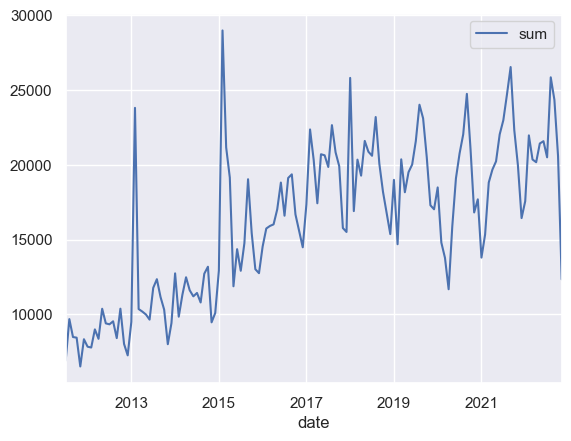

In [7]:
# get the total number of closed calls by month
closed_calls = df_311.groupby(['close_date']).agg({'closed': ['sum']}).reset_index()

# rename the columns
closed_calls.columns = ['date', 'sum']

# set date as the row index
closed_calls = closed_calls.set_index("date")

# take a look
closed_calls.plot()

In [8]:
# it looks like there is some clear seasonality in our data

df_311['close_month'] = df_311['closed_dt'].dt.month
close_month = df_311.groupby(['close_month']).agg({'closed': ['sum']}).reset_index()
close_month.columns = ['month', 'sum']

close_month.sort_values('sum', ascending=False)

,month,sum
8,9.0,218809
7,8.0,218707
9,10.0,197009
6,7.0,195245
1,2.0,192216
5,6.0,187645
2,3.0,181711
4,5.0,180220
3,4.0,172589
0,1.0,169557


In [9]:
# let's take a look at the average gap between opening and closing calls

df_311['open_to_close'] = df_311['closed_dt'] - df_311['open_dt']

# convert to days
df_311['open_to_close'] = df_311['open_to_close'].apply(lambda x: x.days)


# average number of days overall
df_311['open_to_close'].describe()


count    2.217663e+06
mean     1.671363e+01
std      7.615446e+01
min     -1.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.000000e+00
max      2.912000e+03
Name: open_to_close, dtype: float64

In [10]:
# average number of days to close calls by year
df_311.groupby(['close_year'])['open_to_close'].agg('mean')


close_year
2011.0     6.891735
2012.0    14.693035
2013.0    24.652617
2014.0    32.740477
2015.0    24.209018
2016.0    18.506852
2017.0    17.834176
2018.0    17.757748
2019.0    25.347769
2020.0     7.518795
2021.0     6.321454
2022.0     5.929638
Name: open_to_close, dtype: float64

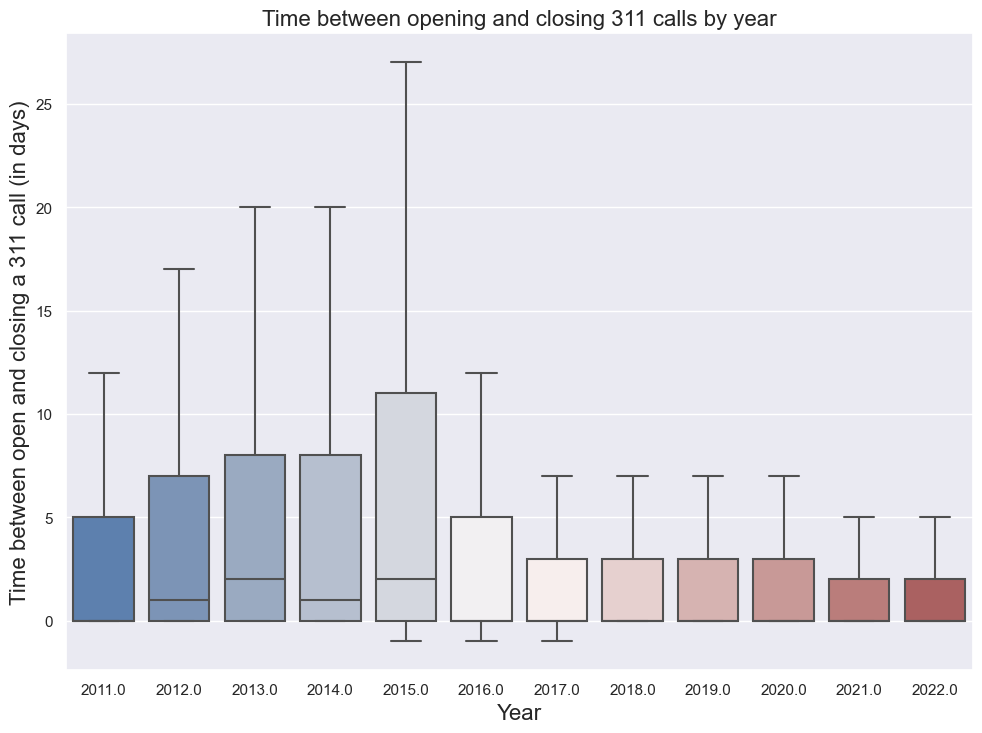

In [11]:
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

# let's take a look at the time between open and close without outliers

sns.boxplot(data = df_311, y='open_to_close', x='close_year', showfliers = False, palette="vlag")
plt.xlabel('Year', fontsize=16)
plt.ylabel('Time between open and closing a 311 call (in days)', fontsize=16)
plt.title("Time between opening and closing 311 calls by year", size='16');

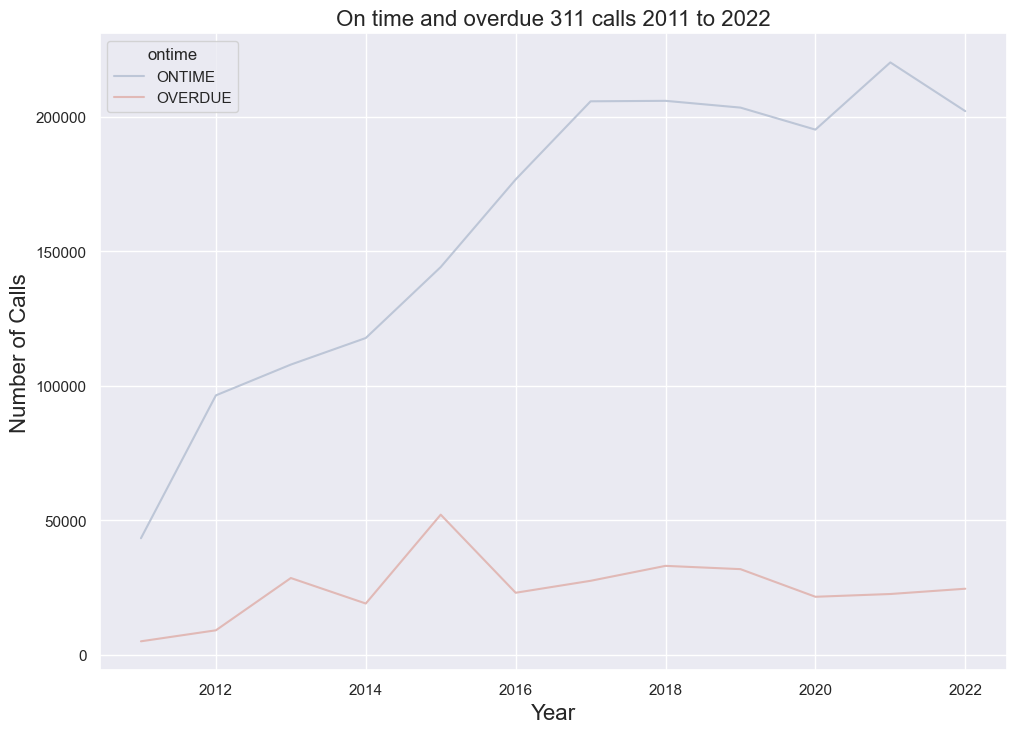

In [12]:
# let's take a look at the ontime and other call related variables

df_311['on_time'] = df_311['ontime'].apply(lambda x: 1 if x=='ONTIME' else 0)


df_ontime  = df_311.groupby("close_year")['ontime'].value_counts(dropna =True).sort_index().reset_index(name="count")  
 
# Setting the Date as index (optional)

# df_solved = df_solved.set_index("Year")

# set a viz theme
sns.set_theme(style="ticks")
sns.set_theme(style="darkgrid")

# plot cases by year
sns.lineplot(x="close_year"
             , y="count"
             , hue="ontime"
             , data=df_ontime
             , palette="vlag")

plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Calls', fontsize=16)
plt.title("On time and overdue 311 calls 2011 to 2022", size='16');

In [13]:
df_311.groupby(['ontime'])['ontime'].count()


ontime
ONTIME     1982395
OVERDUE     461723
Name: ontime, dtype: int64

In [14]:
# let's look at why people called
monthly_calls = df_311.groupby("close_month")['reason'].value_counts(dropna =False).sort_index().reset_index(name="count")   



/Users/jacobpstein/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3199: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


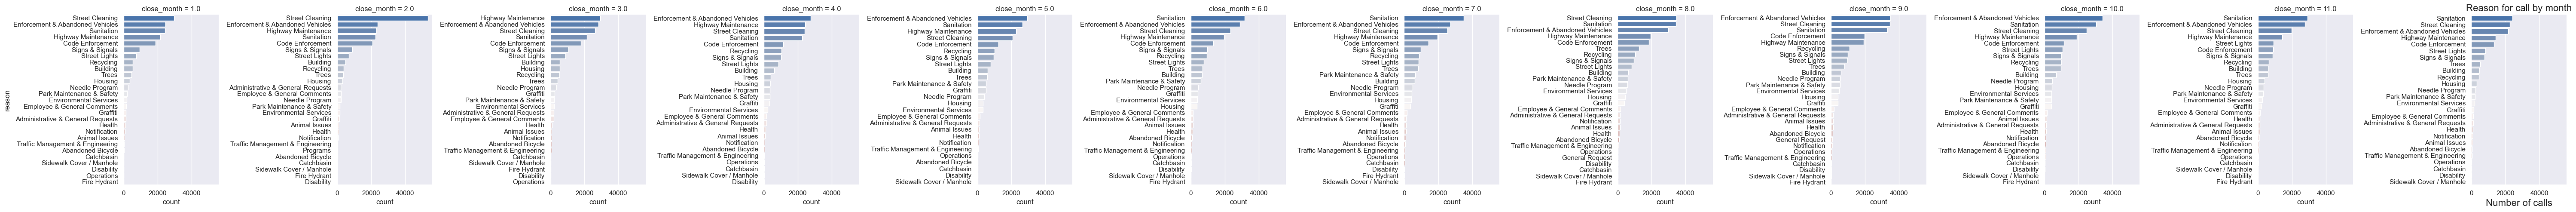

In [15]:
sns.set_theme(style="darkgrid")

sns.catplot(
    data=monthly_calls.loc[monthly_calls['count'] > 100].sort_values(by = 'count', ascending=False), x="count", y="reason", col="close_month",
    kind="bar", sharey = False, palette="vlag"
)
plt.xlabel('Number of calls', fontsize=16)
plt.title("Reason for call by month", size='16');

/Users/jacobpstein/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3199: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


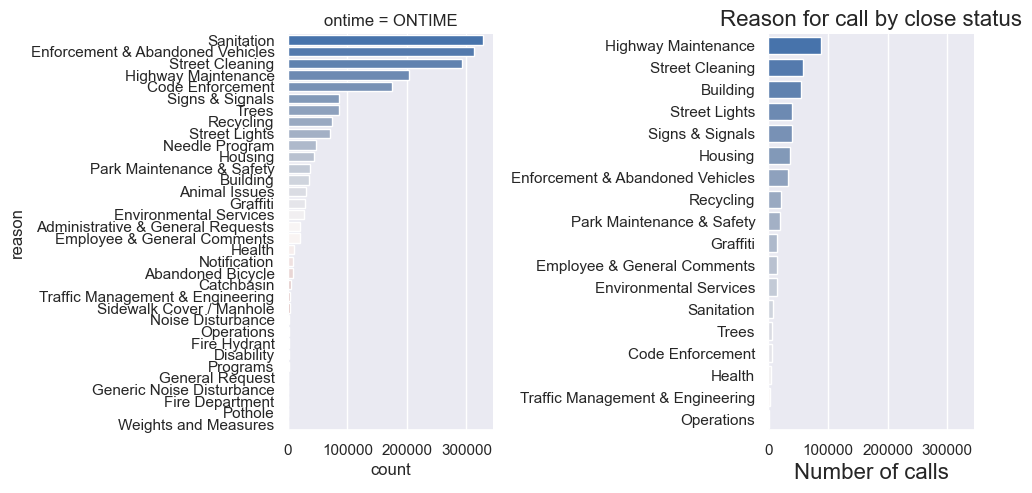

In [16]:
ontime_calls = df_311.groupby("ontime")['reason'].value_counts(dropna =False).sort_index().reset_index(name="count")   

sns.set_theme(style="darkgrid")

sns.catplot(
    data=ontime_calls.loc[ontime_calls['count'] > 500].sort_values(by = 'count', ascending=False), x="count", y="reason", col="ontime",
    kind="bar", sharey = False, palette="vlag"
)

plt.xlabel('Number of calls', fontsize=16)
plt.title("Reason for call by close status", size='16');

/Users/jacobpstein/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3199: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


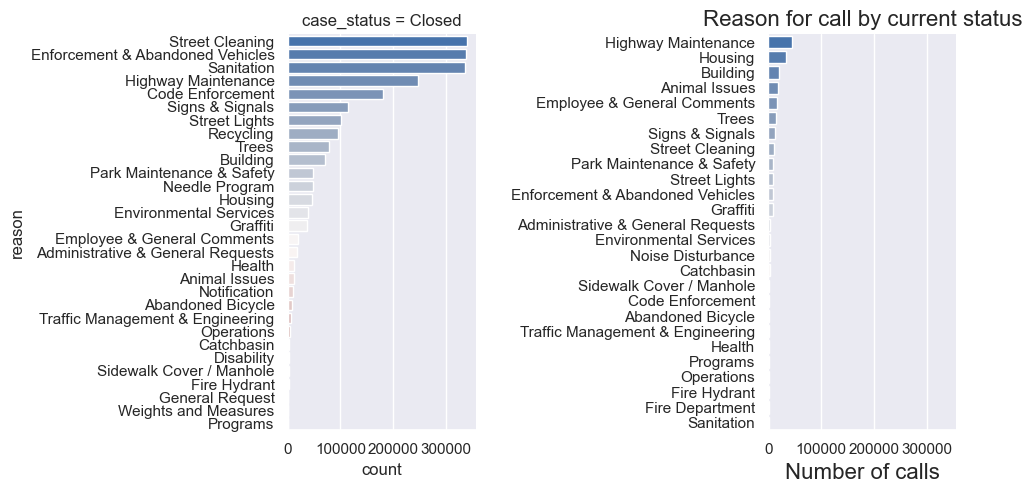

In [17]:
status = df_311.groupby("reason")['case_status'].value_counts(dropna =False).sort_index().reset_index(name="count")   
sns.set_theme(style="darkgrid")

sns.catplot(
    data=status.loc[status['count'] > 500].sort_values(by = 'count', ascending=False), x="count", y="reason", col="case_status",
    kind="bar", sharey = False, palette="vlag"
)

plt.xlabel('Number of calls', fontsize=16)
plt.title("Reason for call by current status", size='16');